which data sets are used?

1. no time adjustment ()
2. time adjustment to fit his el (_AEST)
3. his event log

read base xes files

In [1]:
import pm4py
import pandas as pd
from pytz import timezone

# read and combine all event logs
dfs = []
for i in range(1,6):
    log = pm4py.read_xes('base_xes_files/BPIC15_'+str(i)+'.xes')
    log.head()
    df = pm4py.convert_to_dataframe(log)
    df["r:municipality"] = f"muni-{i}"
    dfs.append(df)
combined_df = pd.concat(dfs, axis=0)


c:\Users\corde\AppData\Local\Programs\Python\Python310\lib\site-packages\pm4py\util\dt_parsing\parser.py:76: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(


parsing log, completed traces ::   0%|          | 0/1199 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/832 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/1409 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/1053 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/1156 [00:00<?, ?it/s]

add australian time

AEST (Australian eastern standard time has no summer/winter time)


In [2]:
# change time back to Amsterdam because pm4py automatically converts to UTC
amsterdam_tz = timezone('Europe/Amsterdam')
combined_df['time:timestamp'] = combined_df['time:timestamp'].dt.tz_convert(
    amsterdam_tz)

# save to file
combined_df.to_csv("data/raw/bpic15.csv", index=False)

# change time to AEST (as in the paper) --> does not work (times are still off)
#aest_tz = timezone('Australia/Sydney')
#combined_df['time:timestamp'] = combined_df['time:timestamp'].dt.tz_convert(aest_tz)

# add 10 hours manually
aest_tz = timezone('UTC')
combined_df['time:timestamp'] = combined_df['time:timestamp'].dt.tz_convert(
    aest_tz)
combined_df['time:timestamp'] = combined_df['time:timestamp'].apply(lambda ts: ts + pd.Timedelta(hours=10))

# save to file
combined_df.to_csv("data/raw/bpic15_AEST.csv", index=False)

perform preprocessing steps


In [3]:
# Load raw data & Preprocess DataFrame (enrich with derived attributes)
logs = ['bpic15', 'bpic15_AEST']

for log in logs:
    fn = f'data/raw/{log}.csv'
    df = pd.read_csv(fn)[[
        'case:concept:name', 'activityNameEN', 'org:resource', 'time:timestamp',
        'case:last_phase', 'case:parts', 'action_code', 'r:municipality'
    ]]
    # Delete all rows were case_id = 4020737 --> Author response: "there is more than one value for attribute “ct:permit_type” 
    df = df[df['case:concept:name'] != 4020737]
    df = df.rename(columns={
        # Resource-related
        "activityNameEN": "activity label",
        # CT-related
        'case:last_phase': 'ct:last_phase',
        # AT-related
        "action_code": "concept:name",
        # Additional
        'case:parts': 'case_parts',
    })
    # TODO: derive 'ct:permit_type', 'at:phase' --> specified by the author
    df = df[~df['case_parts'].isna()]
    df['ct:permit_type'] = df.apply(lambda row: 'Bouw' if 'Bouw' in str(
        row['case_parts']).split(',') else 'Non Bouw', axis=1)

    # only look at the main subprocess: "01_HOOFD"
    df = df[~df['concept:name'].isna()]
    df = df[df['concept:name'].str.startswith('01_HOOFD')]
    df['at:phase'] = df['concept:name'].apply(lambda code: code[:10])

    # Universal (on Disco outputs)
    # derive and append TT related candidate attributes
    df['time:timestamp'] = pd.to_datetime(
        df['time:timestamp'], format='%Y-%m-%d %H:%M:%S.%f')
    MONTHS = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    df['tt:month'] = df['time:timestamp'].apply(lambda ts: MONTHS[ts.month-1])
    df['tt:day'] = df['time:timestamp'].apply(
        lambda ts: 'Day_{}'.format(ts.day))
    WEEKDAYS = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    df['tt:weekday'] = df['time:timestamp'].apply(
        lambda ts: WEEKDAYS[ts.weekday()])
    df['tt:ampm'] = df['time:timestamp'].apply(
        lambda ts: 'AM' if ts.hour < 12 else 'PM')

    print(df)
    df.to_csv(f'data/processed/{log}.csv')

C:\Users\corde\AppData\Local\Temp\ipykernel_4732\3091059455.py:6: DtypeWarning: Columns (21,26,27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(fn)[[


        case:concept:name                    activity label  org:resource  \
0                10009138  register submission date request       9264148   
1                10009138              OLO messaging active       9264148   
2                10009138         send confirmation receipt       9264148   
5                10009138     create procedure confirmation       9264148   
6                10009138      create subcases completeness       9264148   
...                   ...                               ...           ...   
262621            9998898       read publication date field        560600   
262622            9998898     registration date publication        560600   
262623            9998898      stop all running subcases 2b        560600   
262624            9998898                phase case handled        560600   
262625            9998898       read publication date field        560600   

                   time:timestamp          ct:last_phase  \
0       2014-04

C:\Users\corde\AppData\Local\Temp\ipykernel_4732\3091059455.py:6: DtypeWarning: Columns (21,26,27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(fn)[[


        case:concept:name                    activity label  org:resource  \
0                10009138  register submission date request       9264148   
1                10009138              OLO messaging active       9264148   
2                10009138         send confirmation receipt       9264148   
5                10009138     create procedure confirmation       9264148   
6                10009138      create subcases completeness       9264148   
...                   ...                               ...           ...   
262621            9998898       read publication date field        560600   
262622            9998898     registration date publication        560600   
262623            9998898      stop all running subcases 2b        560600   
262624            9998898                phase case handled        560600   
262625            9998898       read publication date field        560600   

                  time:timestamp          ct:last_phase  \
0      2014-04-1

visualize time differences

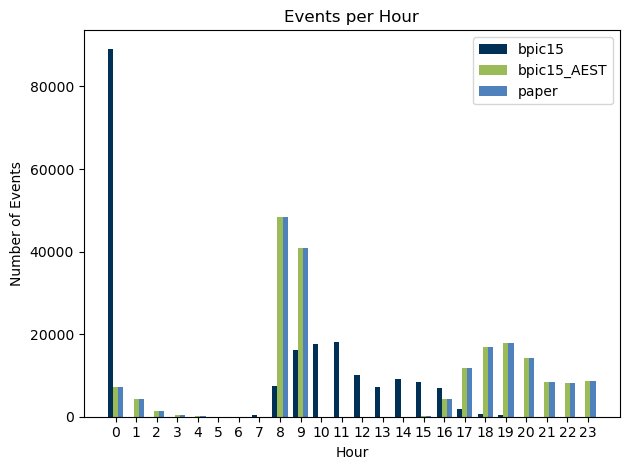

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Create the data
df_bpic15 = pd.read_csv('data/processed/bpic15.csv')
df_bpic15_AEST = pd.read_csv('data/processed/bpic15_AEST.csv')
df_paper = pd.read_csv('data/processed/bpic15_time_manipulated.csv')

# get hours
hours_bpic15 = df_bpic15['time:timestamp'].apply(lambda ts: ts[11:13])
hours_bpic15_AEST = df_bpic15_AEST['time:timestamp'].apply(lambda ts: ts[11:13])
hours_paper = df_paper['time:timestamp'].apply(lambda ts: ts[11:13])

# get counts
hours = np.arange(0, 24)
counts_df_bpic15 = np.bincount(hours_bpic15)
counts_df_bpic15_AEST = np.bincount(hours_bpic15_AEST)
counts_df_paper = np.bincount(hours_paper)

# Ensure that all counts arrays have the same length
max_len = max(len(counts_df_bpic15), len(
    counts_df_bpic15_AEST), len(counts_df_paper))
counts_df_bpic15 = np.pad(
    counts_df_bpic15, (0, max_len - len(counts_df_bpic15)), mode='constant')
counts_df_bpic15_AEST = np.pad(
    counts_df_bpic15_AEST, (0, max_len - len(counts_df_bpic15_AEST)), mode='constant')
counts_df_paper = np.pad(
    counts_df_paper, (0, max_len - len(counts_df_paper)), mode='constant')

# Plot the bar chart
fig, ax = plt.subplots()
width = 0.25  # the width of the bars
x = np.arange(len(hours))

rects1 = ax.bar(x - width, counts_df_bpic15, width,label='bpic15', color='#003056')
rects2 = ax.bar(x, counts_df_bpic15_AEST, width, label='bpic15_AEST', color='#9BBB59')
rects3 = ax.bar(x + width, counts_df_paper, width,label='paper', color='#4F81BD')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Events')
ax.set_xlabel('Hour')
ax.set_title('Events per Hour')
ax.set_xticks(x)
ax.set_xticklabels(hours)
ax.legend()

fig.tight_layout()

plt.show()


train miners


In [6]:

from ordinor.execution_context.rule_based import ODTMiner
def trainMiners(tree_height):
    df_bpic15 = pd.read_csv('data/processed/bpic15.csv')

    df_bpic15_AEST = pd.read_csv('data/processed/bpic15_AEST.csv')

    df_paper = pd.read_csv('data/processed/bpic15_time_manipulated.csv')
    df_paper = df_paper.rename(columns={
        # Resource-related
        "activityNameEN": "activity label",
        "Resource": "org:resource",
        # TT-related
        "Complete Timestamp": "time:timestamp",
        # CT-related
        'case:last_phase': 'ct:last_phase',
        # AT-related
        "Activity": "concept:name",
        # Additional
        'case:parts': 'case_parts',
        "Case ID": "case:concept:name"
    })

    spec = {
        'type_def_attrs': {
            # BPIC15
            'ct:permit_type': {'attr_type': 'categorical', 'attr_dim': 'CT'},
            'at:phase': {'attr_type': 'categorical', 'attr_dim': 'AT'},
            'tt:weekday': {'attr_type': 'categorical', 'attr_dim': 'TT'},
            'tt:ampm': {'attr_type': 'categorical', 'attr_dim': 'TT'},
        }
    }


    # training the miners
    miner_bpic15 = ODTMiner(df_bpic15, spec, max_height=tree_height, trace_history=True)
    miner_bpic15_AEST = ODTMiner(df_bpic15_AEST, spec, max_height=tree_height, trace_history=True)
    miner_paper = ODTMiner(df_paper, spec, max_height=tree_height, trace_history=True)

    return miner_bpic15, miner_bpic15_AEST, miner_paper


#miner_bpic15, miner_bpic15_AEST, miner_paper = trainMiners(tree_height=5)





visualize decision trees


In [ ]:
from tree import TreeNode, TreePrinter
from ordinor.execution_context.rule_based.TreeNode import Node

miners = [miner_bpic15, miner_bpic15_AEST, miner_paper]
miners_suffix = ['', 'bpic15_AEST', '_paper']

# start with preperations for visualizing
for position, miner in enumerate(miners):
    all_nodes_matrix = []
    all_events = []
    for node in miner.l_history_persistent[0]['solution'].values():
        all_events.extend(node.event_ids)

    root_node = Node(
        label=0,
        event_ids=all_events,
        ct_label=None,
        at_label=None,
        tt_label=None)
    root_TreeNode_in_list = []
    root_TreeNode_in_list = [
        TreeNode(root_node.label, root_node.parent_label, root_node, 0, None, [])]
    all_nodes_matrix.append(root_TreeNode_in_list)
    # i to be sure were we are when navigating the tree
    for i, step in enumerate(miner.l_history_persistent):
        all_nodes_this_step = []
        for node in step['solution'].values():
            current_node = TreeNode(
                node.label, node.parent_label, node, i+1, None, [])
            all_nodes_this_step.append(current_node)
        all_nodes_matrix.append(all_nodes_this_step)

    for i, all_nodes_this_step in enumerate(reversed(all_nodes_matrix)):
        for node in all_nodes_this_step:
            if node.parent_label is not None:
                candidate_parent = next((parent_node for parent_node in all_nodes_matrix[len(
                    all_nodes_matrix)-i-2] if parent_node.label == node.parent_label), None)
                if candidate_parent is not None:
                    node.parent = candidate_parent
                else:
                    node.parent = next((parent_node for parent_node in all_nodes_matrix[len(
                        all_nodes_matrix)-i-2] if parent_node.label == node.label))
                if node.parent is not None:
                    node.parent.children.append(node)


    treePrinter = TreePrinter(
        all_nodes_matrix[0][0],  # root node
        7,  # last step
        miner.l_history_persistent,  # miner history
        f'tree{miners_suffix[position]}' # output name
    )

    treePrinter.print_tree_svg()


apply execution contexts to event logs


In [7]:
from ordinor.execution_context.rule_based.Rule import Rule
def addDimensions(df, miner):
    # get different rules
    l_rules_ct, l_rules_at, l_rules_tt = miner._parse_rules_from_leaves(
        miner._leaves)

    # label ATs
    dfs = [r.apply(df, index_only=False).assign(AT_rule=r) for r in l_rules_at]
    df = pd.concat(dfs)

    # label CTs
    dfs = [r.apply(df, index_only=False).assign(CT_rule=r) for r in l_rules_ct]
    df = pd.concat(dfs)

    # label TTs
    dfs = [r.apply(df, index_only=False).assign(TT_rule=r) for r in l_rules_tt]
    df = pd.concat(dfs)

    # add CO_rule as combination of AT CT and TT
    df['CO_rule'] = df.apply(lambda x: Rule(x['AT_rule'].ars+x['CT_rule'].ars+x['TT_rule'].ars), axis=1)

    return df


# have to train miners again because i could not save the trained miners and the miners are changed by the last function
miner_bpic15, miner_bpic15_AEST, miner_paper = trainMiners(tree_height=10) 

df_bpic15 = pd.read_csv('data/processed/bpic15.csv')
df_bpic15 = addDimensions(df_bpic15, miner_bpic15)
df_bpic15.to_csv('data/added_execution_contexts/bpic15.csv', index=False)

df_bpic15_AEST = pd.read_csv('data/processed/bpic15_AEST.csv')
df_bpic15_AEST = addDimensions(df_bpic15_AEST, miner_bpic15_AEST)
df_bpic15_AEST.to_csv('data/added_execution_contexts/bpic15_AEST.csv', index=False)

C:\Users\corde\OneDrive\Documents\GitHub\No-time-to-dice_group_project_IE692\OrdinoR-dev\ordinor\execution_context\rule_based\decision_tree.py:44: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  self._log = el[included_cols]
C:\Users\corde\OneDrive\Documents\GitHub\No-time-to-dice_group_project_IE692\OrdinoR-dev\ordinor\execution_context\rule_based\decision_tree.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._log[const.RESOURCE] = self._log[const.RESOURCE].astype('category')
C:\Users\corde\OneDrive\Documents\GitHub\No-time-to-dice_group_project_IE692\OrdinoR-dev\ordinor\execution_context\rule_based\decision_tree.py:50: SettingWithCopyWarning: 
A value is trying to be se

Decision tree initialized with an empty root node
	Dis. = 0.000000, Imp. = 1.000000, Harmonic Mean. = 0.000000, *** Tree has 1 leaf node(s). ***
Start to fit decision tree with max. height = 10
Tree grows by splitting all current leaf nodes on `tt:weekday`, step=1 (running for 00:00:26s)
	Dis. = 0.001538, Imp. = 0.999829, Harmonic Mean. = 0.003070, *** Tree has 2 leaf node(s). ***
Tree grows by splitting all current leaf nodes on `at:phase`, step=2 (running for 00:00:50s)
	Dis. = 0.003525, Imp. = 0.998203, Harmonic Mean. = 0.007025, *** Tree has 3 leaf node(s). ***
Tree grows by splitting all current leaf nodes on `at:phase`, step=3 (running for 00:01:16s)
	Dis. = 0.003602, Imp. = 0.998144, Harmonic Mean. = 0.007179, *** Tree has 4 leaf node(s). ***
Tree grows by splitting all current leaf nodes on `tt:weekday`, step=4 (running for 00:01:36s)
	Dis. = 0.006606, Imp. = 0.997205, Harmonic Mean. = 0.013125, *** Tree has 6 leaf node(s). ***
Tree grows by splitting all current leaf nodes on 

C:\Users\corde\OneDrive\Documents\GitHub\No-time-to-dice_group_project_IE692\OrdinoR-dev\ordinor\execution_context\rule_based\decision_tree.py:44: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  self._log = el[included_cols]
C:\Users\corde\OneDrive\Documents\GitHub\No-time-to-dice_group_project_IE692\OrdinoR-dev\ordinor\execution_context\rule_based\decision_tree.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._log[const.RESOURCE] = self._log[const.RESOURCE].astype('category')
C:\Users\corde\OneDrive\Documents\GitHub\No-time-to-dice_group_project_IE692\OrdinoR-dev\ordinor\execution_context\rule_based\decision_tree.py:50: SettingWithCopyWarning: 
A value is trying to be se

Decision tree initialized with an empty root node
	Dis. = 0.000000, Imp. = 1.000000, Harmonic Mean. = 0.000000, *** Tree has 1 leaf node(s). ***
Start to fit decision tree with max. height = 10
Tree grows by splitting all current leaf nodes on `at:phase`, step=1 (running for 00:00:26s)
	Dis. = 0.000155, Imp. = 0.999941, Harmonic Mean. = 0.000310, *** Tree has 2 leaf node(s). ***
Tree grows by splitting all current leaf nodes on `tt:weekday`, step=2 (running for 00:00:54s)
	Dis. = 0.000846, Imp. = 0.999770, Harmonic Mean. = 0.001691, *** Tree has 3 leaf node(s). ***
Tree grows by splitting all current leaf nodes on `at:phase`, step=3 (running for 00:01:19s)
	Dis. = 0.003602, Imp. = 0.998144, Harmonic Mean. = 0.007179, *** Tree has 4 leaf node(s). ***
Tree grows by splitting all current leaf nodes on `tt:weekday`, step=4 (running for 00:01:39s)
	Dis. = 0.008072, Imp. = 0.997118, Harmonic Mean. = 0.016015, *** Tree has 6 leaf node(s). ***
Tree grows by splitting all current leaf nodes on 

C:\Users\corde\OneDrive\Documents\GitHub\No-time-to-dice_group_project_IE692\OrdinoR-dev\ordinor\execution_context\rule_based\decision_tree.py:44: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  self._log = el[included_cols]
C:\Users\corde\OneDrive\Documents\GitHub\No-time-to-dice_group_project_IE692\OrdinoR-dev\ordinor\execution_context\rule_based\decision_tree.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._log[const.RESOURCE] = self._log[const.RESOURCE].astype('category')
C:\Users\corde\OneDrive\Documents\GitHub\No-time-to-dice_group_project_IE692\OrdinoR-dev\ordinor\execution_context\rule_based\decision_tree.py:50: SettingWithCopyWarning: 
A value is trying to be se

Decision tree initialized with an empty root node
	Dis. = 0.000000, Imp. = 1.000000, Harmonic Mean. = 0.000000, *** Tree has 1 leaf node(s). ***
Start to fit decision tree with max. height = 10
Tree grows by splitting all current leaf nodes on `tt:weekday`, step=1 (running for 00:00:25s)
	Dis. = 0.001538, Imp. = 0.999829, Harmonic Mean. = 0.003070, *** Tree has 2 leaf node(s). ***
Tree grows by splitting all current leaf nodes on `at:phase`, step=2 (running for 00:00:49s)
	Dis. = 0.000846, Imp. = 0.999770, Harmonic Mean. = 0.001691, *** Tree has 3 leaf node(s). ***
Tree grows by splitting all current leaf nodes on `at:phase`, step=3 (running for 00:01:13s)
	Dis. = 0.003602, Imp. = 0.998144, Harmonic Mean. = 0.007179, *** Tree has 4 leaf node(s). ***
Tree grows by splitting all current leaf nodes on `tt:weekday`, step=4 (running for 00:01:32s)
	Dis. = 0.008072, Imp. = 0.997118, Harmonic Mean. = 0.016015, *** Tree has 6 leaf node(s). ***
Tree grows by splitting all current leaf nodes on 

create visualizations


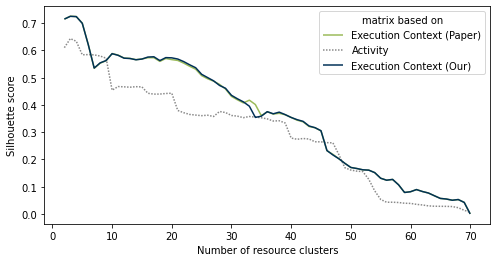

In [8]:
# show results of different miners
from math import log
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('bpic15_amended_typed.csv')

X1 = df.groupby(['Resource', 'Activity']).size().unstack().fillna(0)
X2 = df.groupby(['Resource', 'CO']).size().unstack().fillna(0)


best_k = -1
best_score = -2

l_ss1 = []
l_ss2 = []
for k in range(2, len(X1)):
    clu1 = AgglomerativeClustering(n_clusters=k).fit_predict(X1)
    ss1 = silhouette_score(X1, clu1)
    l_ss1.append(ss1)
    clu2 = AgglomerativeClustering(n_clusters=k).fit_predict(X2)
    ss2 = silhouette_score(X2, clu2)
    l_ss2.append(ss2)



data = []
for i in range(len(l_ss1)):
    data.append({'k': i + 2, 'score': l_ss2[i], 'matrix based on': 'Execution Context (Paper)'})
    data.append({'k': i + 2, 'score': l_ss1[i], 'matrix based on': 'Activity'})


# <add our calculation to graph>
df = pd.read_csv('data/added_execution_contexts/bpic15.csv')

X1 = df.groupby(['org:resource', 'concept:name']).size().unstack().fillna(0)
X2 = df.groupby(['org:resource', 'CO_rule']).size().unstack().fillna(0)

l_ss1 = []
l_ss2 = []
for k in range(2, len(X1)):
    clu1 = AgglomerativeClustering(n_clusters=k).fit_predict(X1)
    ss1 = silhouette_score(X1, clu1)
    l_ss1.append(ss1)
    clu2 = AgglomerativeClustering(n_clusters=k).fit_predict(X2)
    ss2 = silhouette_score(X2, clu2)
    l_ss2.append(ss2)

for i in range(len(l_ss1)):
    data.append({'k': i + 2, 'score': l_ss2[i], 'matrix based on': 'Execution Context (Our)'})
    #data.append({'k': i + 2, 'score': l_ss1[i], 'matrix based on': 'Activity_our'}) # not needed because same as above
# </add our calculation to graph>

data = pd.DataFrame(data)

data

f, ax = plt.subplots(figsize=(8, 4))
ax = sns.lineplot(data=data, x="k", y="score", ax=ax,
                  hue="matrix based on", style='matrix based on', 
                  palette={'Execution Context (Paper)': '#9BBB59',
                        'Activity': '#898989',
                        'Execution Context (Our)': '#003056'}, 
                    dashes={'Execution Context (Paper)': (1, 0),
                            'Activity': (1,1),
                            'Execution Context (Our)': (1, 0)})
plt.xlabel('Number of resource clusters')
plt.ylabel("Silhouette score")
plt.show()
f.savefig("graphs/omm_all.pdf", bbox_inches='tight')


Resource
560781      12644
560454      10170
560872       9503
560530       9295
560673       9243
            ...  
1898401         9
13412010        9
3175153         7
10716070        5
560427          2
Length: 71, dtype: int64
[560781, 560454, 560872, 560530, 560673, 560604, 560752, 560602, 560532, 560749, 2670601, 560890, 560741, 3273854, 560458, 560600, 560852, 2013365, 560519, 560429, 1254625, 1550894, 560912, 560696, 560821, 560521, 560608, 560925, 8492512, 560598, 11744364, 5025869, 3442724, 560596, 560462, 560881, 560613, 9264148, 22445896, 4634935, 560849, 560812, 560950, 3122446, 560894, 560594, 6993893, 560589, 20987361, 9106499, 5726485, 560922, 12941730, 560999, 560431, 6925826, 560528, 560464, 6, 3069866, 13412649, 11345232, 560796, 4936828, 560713, 3148844, 1898401, 13412010, 3175153, 10716070, 560427]
0     [560852, 1254625, 3148844, 560532, 560749, 560...
1     [560849, 560532, 560604, 560872, 560600, 56053...
2     [560849, 560429, 560604, 560532, 560922, 56087...


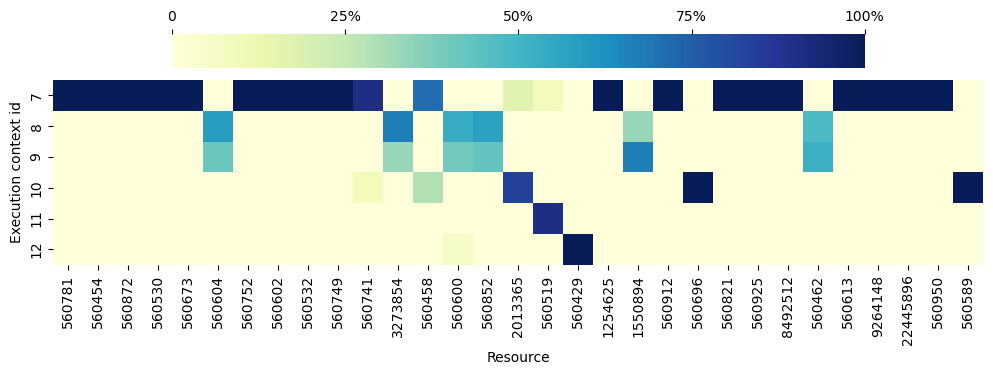

In [ ]:
# matrix from paper
from collections import defaultdict

df = pd.read_csv('bpic15_amended_typed.csv')

df_res_events = df.groupby('Resource').size().sort_values(ascending=False).iloc[:]
print(df_res_events)
active_res = list(df_res_events.index)
print(active_res)

df = df[df['Resource'].isin(active_res)]


df_co_events = df.groupby(['AT', 'TT']).size(
).reset_index().sort_values(0, ascending=False)
df_co_events = df_co_events.rename(columns={0: 'n_events'}).reset_index()[
    ['AT', 'TT', 'n_events']]

df_co_res = df.groupby(['AT', 'TT'])['Resource'].unique()

df_x = df_co_events.join(df_co_res, on=['AT', 'TT'])
print(df_x['Resource'])

all_resources = sorted(df['Resource'].unique())

selected_resources = set()

# Jaccard distance
co_resources = []

for i, res in enumerate(df_x['Resource']):
    # print(set(sorted(res)))
    if i >= 6:
        for r in res:
            selected_resources.add(r)
    co_resources.append(set(res))

print(sorted(selected_resources))
print(len(selected_resources))

selected_resources = sorted(
    selected_resources, key=lambda x: active_res.index(x))
print(df_res_events.loc[selected_resources])

df_res_co_events = defaultdict(lambda: defaultdict(lambda: 0))
for key, events in df.groupby(['Resource', 'AT', 'TT']):
    r = key[0]
    at = key[1]
    tt = key[2]
    if at == '0-1-4-5' and tt == 'Sun':
        co = '7'
    elif at == '3' and tt == 'Sat':
        co = '8'
    elif at == '2' and tt == 'Sat':
        co = '9'
    elif at == '6' and tt == 'M-T-W-T-F':
        co = '10'
    elif at == '8' and tt == 'Sat':
        co = '11'
    elif at == '7' and tt == 'Sat':
        co = '12'
    else:
        co = 'others'
    df_res_co_events[r][co] = len(events)

df_res_co_events = pd.DataFrame(df_res_co_events).fillna(0).T
df_res_co_events = df_res_co_events[['7', '8', '9', '10', '11', '12']]
df_res_co_events = df_res_co_events.loc[selected_resources]
df_res_co_events = df_res_co_events.div(df_res_co_events.sum(axis=1), axis=0)

mat_jac_dist = defaultdict(lambda: defaultdict(lambda: 0))

for i in range(len(co_resources)):
    for j in range(len(co_resources)):
        u = co_resources[i]
        v = co_resources[j]
        mat_jac_dist[i+1][j+1] = 1 - len(u.intersection(v)) / len(u.union(v))

print(mat_jac_dist)

df_jac_dist = pd.DataFrame(mat_jac_dist).loc[1:7][list(range(1, 7+1))]
# df_jac_dist

f, ax = plt.subplots(figsize=(12, 3))
sns.heatmap(df_res_co_events.T, ax=ax, cmap='YlGnBu', annot=False,
            cbar_kws=dict(use_gridspec=False, location="top"))
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, .25, .5, .75, 1])
cbar.set_ticklabels(['0', '25%', '50%', '75%', '100%'])
plt.xlabel("Resource")
plt.ylabel("Execution context id")
plt.show()
f.savefig("graphs/res_prof_paper.pdf", bbox_inches='tight')
